# Final Project: Interior Design Classification
## Load data

In [1]:
import os
import time
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
print(tf.__version__)
print(keras.__version__)
print(PIL.__version__)

2.4.1
2.4.3
7.2.0


## Define variable

In [2]:
TRAIN_DIR = '../input/data-interiors/v5.0/train'
VAL_DIR = '../input/data-interiors/v5.0/val'
TEST_DIR = '../input/data-interiors/v5.0/test'
BATCH_SIZE = 64
EPOCHS = 25
TARGET_SIZE = (224, 224)
IMAGE_CHANNELS=3
BASEMODEL_PATH = 'models/base_model.h5'
BESTMODEL_PATH = 'models/best_model.h5'
BESTWEIGHTS_PATH = 'models/best_weights.h5'
HISTORY_PATH = 'models/history.npy'

PROJECT_ROOT_DIR = "."
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODELS_PATH, exist_ok=True)

## Get all labels

In [3]:
# Get list subfolder
list_subfolder = os.listdir(TRAIN_DIR)
list_subfolder = sorted(list_subfolder)
print('All labels : ', list_subfolder)

All labels :  ['ArtDecor', 'Hitech', 'Indochina', 'Industrial', 'Scandinavian']


## Define function get info data

In [4]:
import pandas as pd

def get_data(DIR):
    LABELS = []
    IMAGES = []
    for subfolder in list_subfolder:
        sunfolder_path = os.path.join(DIR, subfolder)
        print(sunfolder_path)
        for file_name in os.listdir(sunfolder_path):
            file_path = os.path.join(subfolder, file_name)
            IMAGES.append(file_path)
            LABELS.append(subfolder)
    df = pd.DataFrame({
        'image': IMAGES,
        'label': LABELS
    })
    df.head()
    return df

## Define function show info data

In [5]:
def plot_count(df, title=''):
    print(df.label.value_counts())
    df.label.value_counts().plot(kind='barh', 
                                 figsize=(10,5),
                                 title=title,
                                 color=plt.cm.Set2(np.arange(len(df))),
                                 rot=0)
    for i, v in df.label.value_counts().reset_index().iterrows():
        plt.text(v.label + 5, i - 0.1 , v.label, color='black')
    plt.show()

## Get label and file path data Train Data

In [6]:
### Get data to dataframe
df_train = get_data(TRAIN_DIR)

../input/data-interiors/v5.0/train/ArtDecor
../input/data-interiors/v5.0/train/Hitech
../input/data-interiors/v5.0/train/Indochina
../input/data-interiors/v5.0/train/Industrial
../input/data-interiors/v5.0/train/Scandinavian


In [7]:
### Save data to csv
df_train.to_csv('df_train.csv')

Indochina       1888
Hitech          1622
Industrial      1503
ArtDecor        1386
Scandinavian    1348
Name: label, dtype: int64


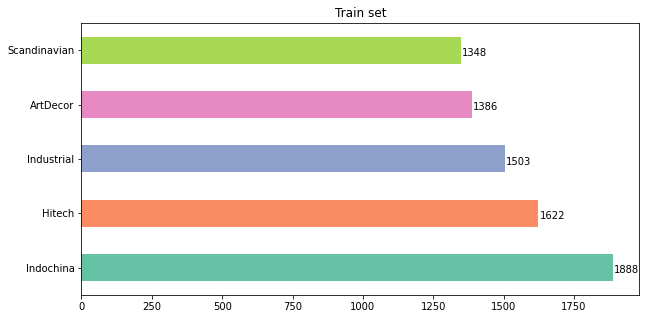

In [8]:
### Plot count sample
plot_count(df_train, title="Train set")

## Get label and file path data Val Data

In [9]:
### Get data to dataframe
df_val = get_data(VAL_DIR)

../input/data-interiors/v5.0/val/ArtDecor
../input/data-interiors/v5.0/val/Hitech
../input/data-interiors/v5.0/val/Indochina
../input/data-interiors/v5.0/val/Industrial
../input/data-interiors/v5.0/val/Scandinavian


In [10]:
### Save data to csv
df_val.to_csv('df_val.csv')

Indochina       470
Hitech          400
Industrial      370
ArtDecor        350
Scandinavian    340
Name: label, dtype: int64


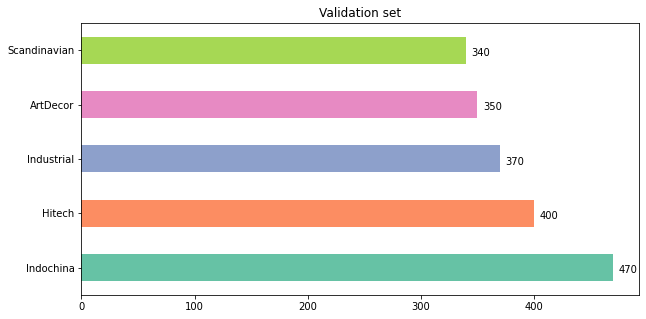

In [11]:
### Plot count sample
plot_count(df_val, title="Validation set")

## Get label and file path data Test Data

In [12]:
### Get data to dataframe
df_test = get_data(TEST_DIR)

../input/data-interiors/v5.0/test/ArtDecor
../input/data-interiors/v5.0/test/Hitech
../input/data-interiors/v5.0/test/Indochina
../input/data-interiors/v5.0/test/Industrial
../input/data-interiors/v5.0/test/Scandinavian


In [13]:
### Save data to csv
df_test.to_csv('df_test.csv')

Scandinavian    500
Indochina       500
Hitech          500
ArtDecor        500
Industrial      500
Name: label, dtype: int64


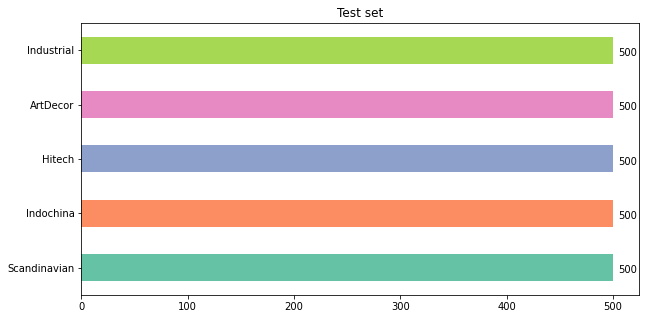

In [14]:
### Plot count sample
plot_count(df_test, title="Test set")

## Data Augmentation

In [15]:
### train_set with ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator,load_img ,img_to_array
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=7,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   horizontal_flip=True)
train_set = train_datagen.flow_from_dataframe(dataframe=df_train,
                                              directory=TRAIN_DIR,
                                              x_col="image",
                                              y_col="label",
                                              shuffle=True,
                                              class_mode="sparse",
                                              batch_size=BATCH_SIZE,
                                              target_size=TARGET_SIZE)

Found 7747 validated image filenames belonging to 5 classes.


In [16]:
### Show demo Data Augmentation
example_df = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAIN_DIR,
    x_col="image",
    y_col="label",
    target_size=TARGET_SIZE,
    class_mode='sparse'
)

Found 1 validated image filenames belonging to 1 classes.


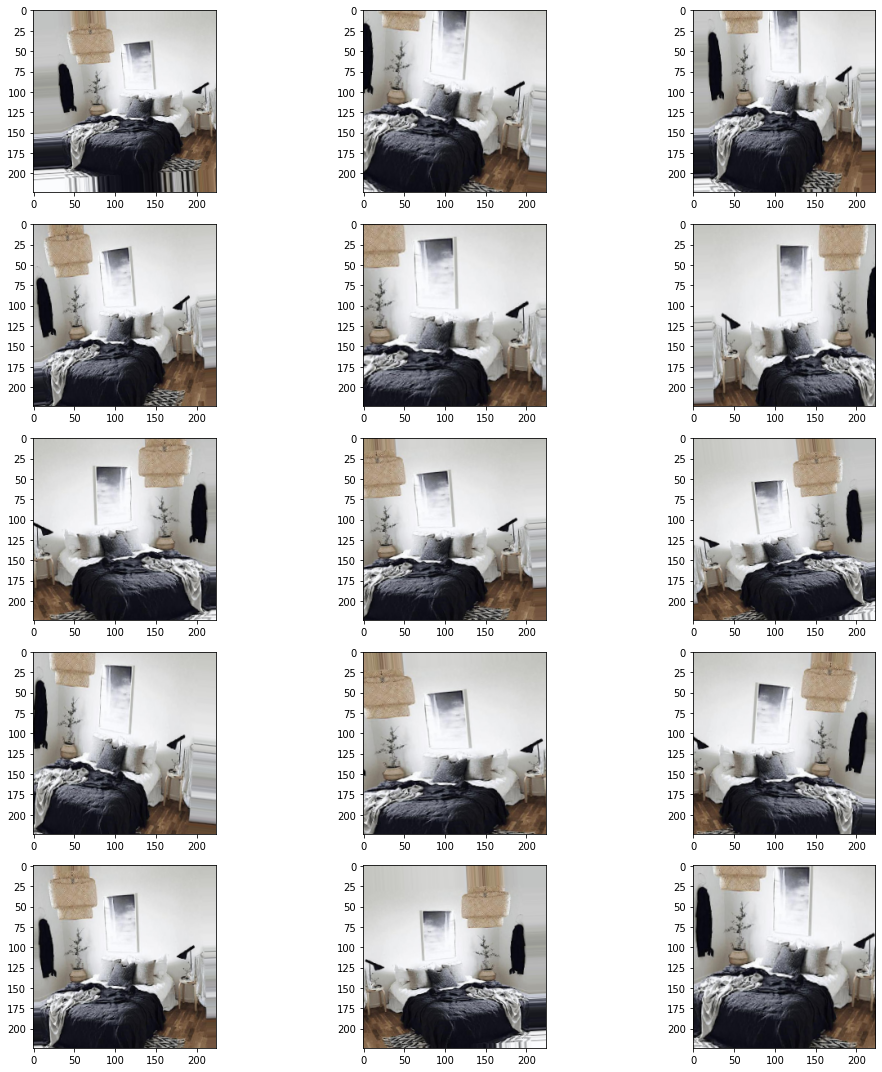

In [17]:
### Show image demo
plt.figure(figsize=(15, 15))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
### val_set with ImageDataGenerator
val_datagen = ImageDataGenerator(rescale=1./255)
val_set = val_datagen.flow_from_dataframe(dataframe=df_val,
                                          directory=VAL_DIR,
                                          x_col="image",
                                          y_col="label",
                                          class_mode="sparse", 
                                          batch_size=BATCH_SIZE,
                                          target_size=TARGET_SIZE)

Found 1930 validated image filenames belonging to 5 classes.


## Build model

In [19]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.xception import Xception
from keras.applications import VGG19, ResNet50, NASNetLarge, DenseNet201, VGG16, \
InceptionResNetV2, Xception, ResNet152, InceptionV3, DenseNet121, ResNet50V2
from keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout,\
MaxPooling2D, Conv2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Sequential
import tensorflow as tf
import numpy as np
import os

if os.path.exists(BASEMODEL_PATH):
    os.remove(BASEMODEL_PATH)
    print("The file removed successfully!")
else:
    print("The file does not exist")

tf.random.set_seed(42)
np.random.seed(42)

# build model
def define_model_():
    base_model = InceptionV3(weights="imagenet", 
                          include_top=False, 
                          input_shape=(224, 224, 3))
    
#     for layer in base_model.layers:
#         layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(128, activation='elu', kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    return model

def define_model():
    
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

#         Conv2D(64, (1, 1), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3)),
        Dropout(0.2),
        
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
        
#         Conv2D(128, (1, 1), activation='relu', input_shape=(224, 224, 3)),
#         MaxPooling2D(pool_size=(2, 2)),

#         Conv2D(64, (3, 3), activation='relu'),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D(pool_size=(2, 2)),
#         Dropout(0.25),
        
#         Conv2D(32, (3, 3), activation='relu'),
#         Conv2D(32, (3, 3), activation='relu'),
#         MaxPooling2D(pool_size=(3, 3)),
#         Dropout(0.25),
        
#         Flatten(),
#         Dense(128, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.25),
#         Dense(64, activation='relu'),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(5, activation='softmax')
    ])

    return model


# model = define_model()
model = keras.models.load_model('../input/model-customer-interiors/MadeInThaiLan.h5')
model.summary()
# if os.path.exists(BASEMODEL_PATH):
#     os.remove(BASEMODEL_PATH)
# model.save(BASEMODEL_PATH)

The file does not exist
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 44, 44, 180)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 180)       291780    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 140)       226940    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 38, 38, 100)       126100    
_________________________________________________________________
conv2d_5 (Conv2D)            (No

In [20]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=0.1):
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    init_weights = model.get_weights()
    iterations = math.ceil(len(X)) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, 
                        validation_data=y, 
                        epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    print("{} => {}".format("GL", "Good Loss"))
    print("{} => {}".format("BLL", "Bad Loss Lastest"))
    plt.figure(figsize=(10,5))
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses))])
    
    good_loss = [rates[losses.index(min(losses))], min(losses)]
    plt.plot(good_loss[0], good_loss[1], 'go')
    plt.text(good_loss[0], good_loss[1]+10**-2, 
             "GL: (lr = {:f})".format(good_loss[0]), fontsize=12)
    
    bad_index_lastest = losses.index(min(losses))
    for index in range(losses.index(min(losses))+1, losses.index(min(losses))+20):
        if (losses[index] > losses[bad_index_lastest]) and (losses[index] < 1.6):
            bad_index_lastest = index
        else: break
    bad_loss_lastest = [rates[bad_index_lastest], losses[bad_index_lastest]]
    plt.plot(bad_loss_lastest[0], bad_loss_lastest[1], 'ro')
    plt.text(bad_loss_lastest[0], bad_loss_lastest[1]+10**-2, 
             "BLL: (lr = {:f})".format(bad_loss_lastest[0]), fontsize=12)
    
    good_lr = good_loss[0]
    
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.ylim(0, 3)
    return good_lr

122/122 [==============================] - 1328s 11s/step - loss: 0.3760 - accuracy: 0.8801 - val_loss: 3.4889 - val_accuracy: 0.2332
GL => Good Loss
BLL => Bad Loss Lastest
Good learning rate: 3.103155177086592e-05


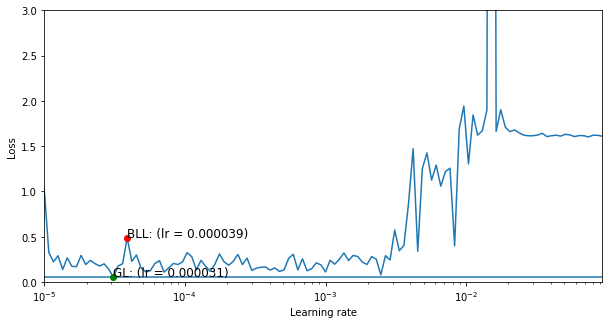

In [21]:
from keras.models import load_model

tf.random.set_seed(42)
np.random.seed(42)

model = load_model("../input/model-customer-interiors/MadeInThaiLan.h5")
batch_size = BATCH_SIZE
rates, losses = find_learning_rate(model, train_set, val_set, epochs=1, batch_size=batch_size)
good_lr = plot_lr_vs_loss(rates, losses)
print('Good learning rate: {}'.format(good_lr))

In [22]:
### save history
import pickle

# In case you want to create a checkpoint
with open('rates_losses_find_learning_rate.pickle', 'wb') as f:
    pickle.dump((rates, losses), f)

In [23]:
# In case you want to create a checkpoint
with open('rates_losses_find_learning_rate.pickle', 'rb') as f:
    rates_, losses_ = pickle.load(f)

len(rates_), len(losses_)

(122, 122)

## Training model

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Nadam, Adam

tf.random.set_seed(42)
np.random.seed(42)

model = load_model("../input/model-customer-interiors/MadeInThaiLan.h5")
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= Adam(learning_rate=good_lr), 
              metrics=["accuracy"])

print(model.optimizer.lr)

modelCheckpoint = ModelCheckpoint(
    BESTMODEL_PATH,
    monitor="val_loss",
    save_best_only=True,
)
earlyStopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=1/3, #1/3, 
                                            min_lr=1e-6)

### calculator execution time
start_time = time.time()
history = model.fit(train_set, 
                    validation_data=val_set,
                    epochs=EPOCHS,
                    callbacks=[modelCheckpoint, earlyStopping, learning_rate_reduction])
end_time = time.time()


<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3.103155e-05>
Epoch 1/25
122/122 [==============================] - 1278s 10s/step - loss: 0.2243 - accuracy: 0.9328 - val_loss: 0.4873 - val_accuracy: 0.8528
Epoch 2/25
122/122 [==============================] - 1275s 10s/step - loss: 0.1794 - accuracy: 0.9435 - val_loss: 0.4682 - val_accuracy: 0.8648
Epoch 3/25
122/122 [==============================] - 1276s 10s/step - loss: 0.1790 - accuracy: 0.9437 - val_loss: 0.4540 - val_accuracy: 0.8736
Epoch 4/25
122/122 [==============================] - 1276s 10s/step - loss: 0.1564 - accuracy: 0.9488 - val_loss: 0.4721 - val_accuracy: 0.8715

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0343850590288639e-05.
Epoch 5/25
122/122 [==============================] - 1277s 10s/step - loss: 0.1446 - accuracy: 0.9530 - val_loss: 0.4615 - val_accuracy: 0.8756
Epoch 6/25
122/122 [==============================] - 1276s 10s/step - loss: 0.1554 - accuracy: 0.9519 - val_loss: 0.4

In [25]:
### Infor train time information and average time for a epochs
execution_time = end_time - start_time
print('Training time: ', execution_time)
print('Number of epochs: ', len(history.history["loss"]))
print('Average time for a epochs: ', execution_time / len(history.history["loss"]))

Training time:  12766.619208574295
Number of epochs:  10
Average time for a epochs:  1276.6619208574295


In [26]:
### save history
import pickle

# In case you want to create a checkpoint
with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [27]:
# In case you want to create a checkpoint
with open('history.pickle', 'rb') as f:
    history_ = pickle.load(f)
len(history_)

5

## Evaluate model

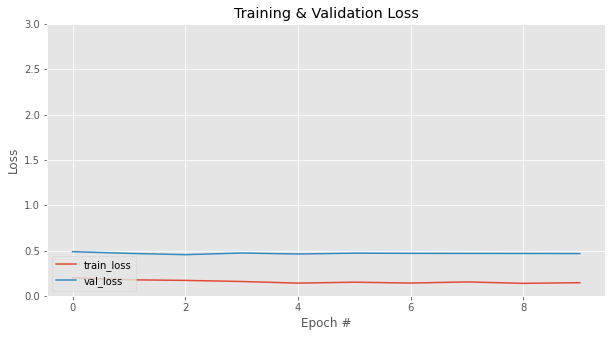

In [28]:
### Plot loss and accuracy train, val
history = history_
epochs_ = len(history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (10, 5))
plt.plot(np.arange(0, epochs_), history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_), history["val_loss"], label="val_loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.ylim(0, 3)
plt.show()

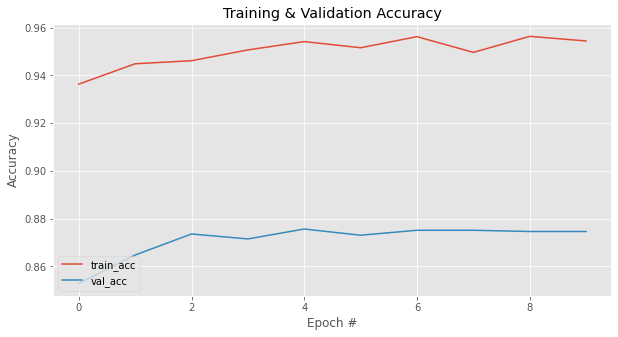

In [29]:
epochs_ = len(history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (10, 5))
plt.plot(np.arange(0, epochs_), history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs_), history["val_accuracy"], label="val_acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

In [30]:
df_test = df_test.sort_values(by=['label'])
df_test

,image,label
0,ArtDecor/ArtDecor_02237.jpg,ArtDecor
341,ArtDecor/ArtDecor_01829.jpg,ArtDecor
340,ArtDecor/ArtDecor_02002.jpg,ArtDecor
339,ArtDecor/ArtDecor_01955.jpg,ArtDecor
338,ArtDecor/ArtDecor_02172.jpg,ArtDecor
...,...,...
2158,Scandinavian/Scandinavian_01856.jpg,Scandinavian
2157,Scandinavian/Scandinavian_01813.jpg,Scandinavian
2156,Scandinavian/Scandinavian_01834.jpg,Scandinavian
2169,Scandinavian/Scandinavian_01913.jpg,Scandinavian


In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory=TEST_DIR,
                                            x_col="image",
                                            y_col="label",
                                            class_mode="categorical", 
                                            batch_size=BATCH_SIZE,
                                            target_size=TARGET_SIZE,
                                            shuffle=False)

Found 2500 validated image filenames belonging to 5 classes.


In [32]:
### Predict with test dataset
nb_samples = df_test.shape[0]
predict = model.predict(test_set, steps=np.ceil(nb_samples/BATCH_SIZE))

In [33]:
### get 
np.unique(test_set.classes)
y_pred = np.argmax(predict, axis=1)

In [34]:
### Show Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=list_subfolder))

Classification Report
              precision    recall  f1-score   support

    ArtDecor       0.94      0.91      0.92       500
      Hitech       0.97      0.95      0.96       500
   Indochina       0.93      0.97      0.95       500
  Industrial       0.90      0.93      0.91       500
Scandinavian       0.95      0.93      0.94       500

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



#### Show Confusion Matrix

In [35]:
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
print(cm)

Confusion Matrix
[[453   4  15  16  12]
 [  5 475   4  11   5]
 [  7   0 485   8   0]
 [  5   3  18 464  10]
 [ 10   6   2  18 464]]


<AxesSubplot:>

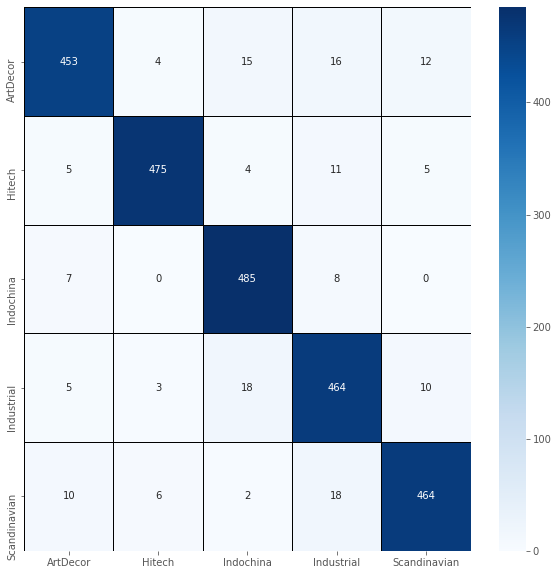

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(cm , index = list_subfolder , columns = list_subfolder)
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , 
            linewidth = 1 , annot = True, fmt='' , 
            xticklabels = list_subfolder , yticklabels = list_subfolder)